In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg as la

import warnings
warnings.filterwarnings("ignore")
import pandas as pd

from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn import datasets
import seaborn as sns

### Dimensionality Reduction

The dimension of our data is the same as number of features the data has. The higher the dimension, the harder it is to work with the data due to multitude of reasons:

1. We have more variables and so more parameters.
2. More likely that a lot of features are redundant.
3. The higher the dimension, the more sparse is our data, which means it is harder to cluster the data in a meanignful way (Curse of Dimensionality).
4. Easier to overfit.
5. More memory needed and bigger computational complexity.

To combat these drawbacks, we often use dimensionality reducing techniques. 

### PCA (Principal Component Analysis)

The main idea of PCA is this: project data into lower dimension in such a way that we preserve as much information as possible. This means we want to keep separation of points as much as possible, which in turn means we want to find direction along which our data is spread the most (has largest variance).

PCA does this in the following way:

1. Standardize the data (center it around the mean)
2. Find covariances to see the relationships between features and the spread.
3. Find Principal Components: these are eigenvectors of covariance matrix ordered in descending order of eigenvalues. (These are the direction of largest spread)
4. Choose how many dimension you want to have and multiply you data matrix by needed amount of principal components. (Projection onto lower dimension)

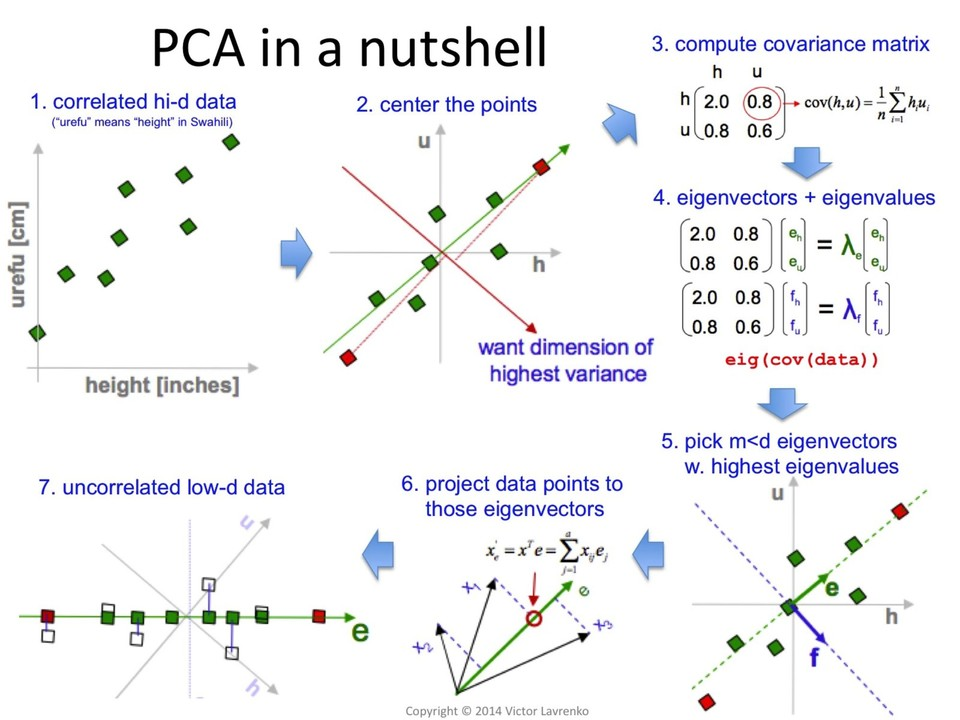

In [2]:
dataset=datasets.load_iris()
X = dataset.data
y = dataset.target

In [3]:
df=pd.DataFrame(data= np.c_[dataset['data'], dataset['target']],
                     columns= dataset['feature_names'] + ['target'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


So we have 4 dimensions. Let's reduce to 2 dimension. Before we do this let's normalize the data and compare covariance matrix and pairplots

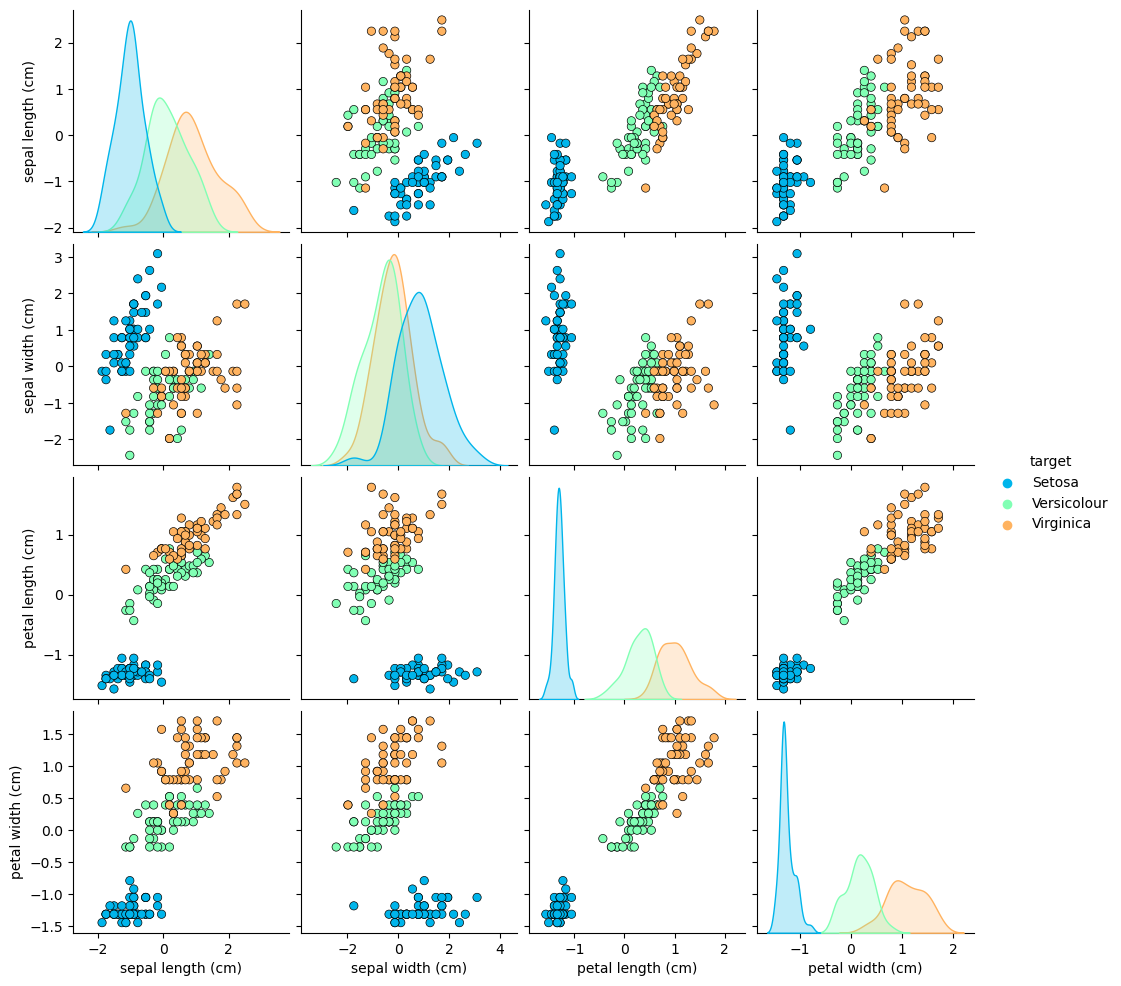

In [4]:
Xn=(X-X.mean(axis=0))/X.std(axis=0)
df=pd.DataFrame(data= np.c_[Xn,y],
                     columns= dataset['feature_names'] + ['target'])
label_dict = {0:'Setosa',1:'Versicolour', 2:'Virginica'}
df['target']=df.target.map(label_dict)
sns.pairplot(data=df, hue='target', palette='rainbow', plot_kws={'edgecolor':'k'})
plt.show()

In [5]:
C=np.cov(Xn.T)
C

array([[ 1.00671141, -0.11835884,  0.87760447,  0.82343066],
       [-0.11835884,  1.00671141, -0.43131554, -0.36858315],
       [ 0.87760447, -0.43131554,  1.00671141,  0.96932762],
       [ 0.82343066, -0.36858315,  0.96932762,  1.00671141]])

In [6]:
val, vec=np.linalg.eig(C)
val

array([2.93808505, 0.9201649 , 0.14774182, 0.02085386])

In [7]:
vec

array([[ 0.52106591, -0.37741762, -0.71956635,  0.26128628],
       [-0.26934744, -0.92329566,  0.24438178, -0.12350962],
       [ 0.5804131 , -0.02449161,  0.14212637, -0.80144925],
       [ 0.56485654, -0.06694199,  0.63427274,  0.52359713]])

In this case, the first column of `vec` matrix is the first principal component since it is the eigenvector corresponding to the largest eigenvalue (2.93). The second column is the second principal component and so on. Each of those vectors consists of weights that we apply to corresponding feature and get the correst direction. In other words: $$PC1= 0.521x_1-0.269x_2+0.58x_3+0.565x_4$$ where $x_1, ..., x_4$ are features.

Since we want just two dimesions, we can project our data onto first two principal components:

In [8]:
Xpca=Xn.dot(vec[:,:2])
Xpca

array([[-2.26470281, -0.4800266 ],
       [-2.08096115,  0.67413356],
       [-2.36422905,  0.34190802],
       [-2.29938422,  0.59739451],
       [-2.38984217, -0.64683538],
       [-2.07563095, -1.48917752],
       [-2.44402884, -0.0476442 ],
       [-2.23284716, -0.22314807],
       [-2.33464048,  1.11532768],
       [-2.18432817,  0.46901356],
       [-2.1663101 , -1.04369065],
       [-2.32613087, -0.13307834],
       [-2.2184509 ,  0.72867617],
       [-2.6331007 ,  0.96150673],
       [-2.1987406 , -1.86005711],
       [-2.26221453, -2.68628449],
       [-2.2075877 , -1.48360936],
       [-2.19034951, -0.48883832],
       [-1.898572  , -1.40501879],
       [-2.34336905, -1.12784938],
       [-1.914323  , -0.40885571],
       [-2.20701284, -0.92412143],
       [-2.7743447 , -0.45834367],
       [-1.81866953, -0.08555853],
       [-2.22716331, -0.13725446],
       [-1.95184633,  0.62561859],
       [-2.05115137, -0.24216355],
       [-2.16857717, -0.52714953],
       [-2.13956345,

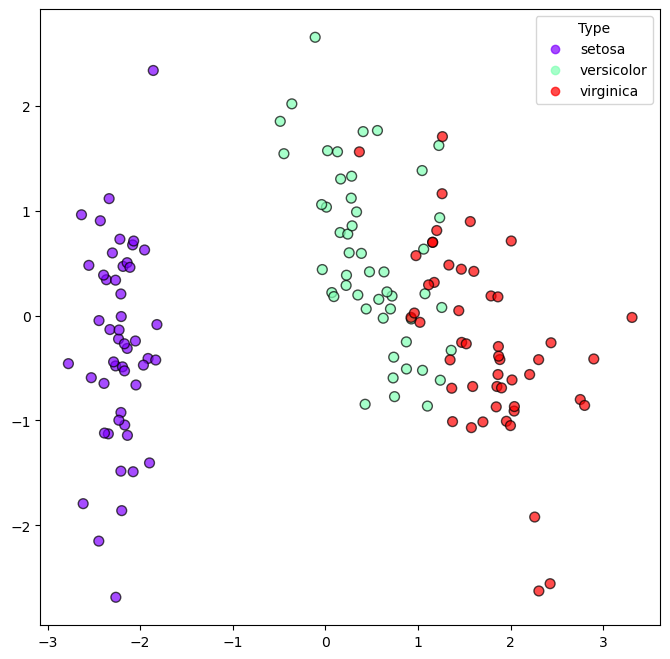

In [9]:
plt.figure(figsize=(8,8))
ax = plt.scatter(x=Xpca[:, 0], y=Xpca[:, 1], c=y,s=50, cmap='rainbow', edgecolor='k',alpha=.7)    

plt.legend(ax.legend_elements(prop='colors')[0], dataset.target_names, title='Type')
ax.legend_elements(prop='colors', num=None)
plt.show()

We can also measure how much information we preserve using eigenvalues:

In [10]:
expvar=val[: 2].sum()/val[:].sum()
print(f'Explained Variance Ratio is {expvar :.3}')

Explained Variance Ratio is 0.958


Let's implement this using PCA library form sklearn:

In [11]:
pca = PCA(n_components=2)
Xpca2=pca.fit_transform(Xn)

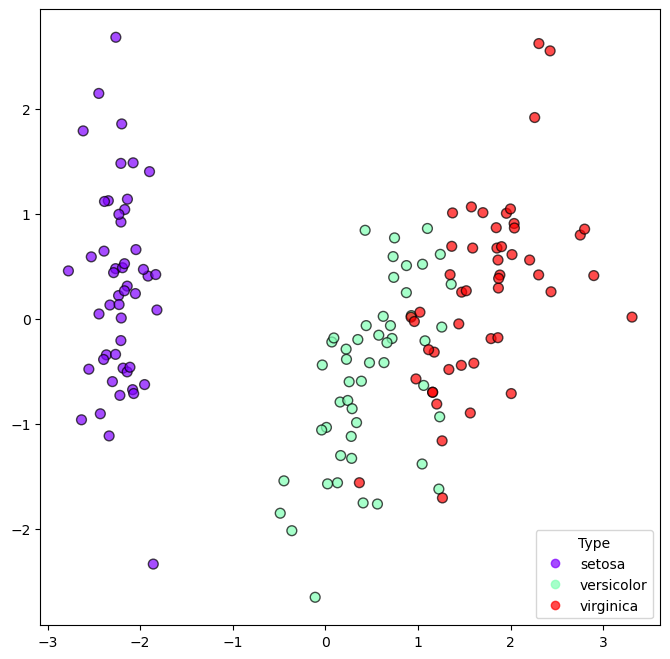

In [12]:
plt.figure(figsize=(8,8))
ax = plt.scatter(x=Xpca2[:, 0], y=Xpca2[:, 1], c=y, s=50, cmap='rainbow', edgecolor='k',alpha=.7)    

plt.legend(ax.legend_elements(prop='colors')[0], dataset.target_names, title='Type')
ax.legend_elements(prop='colors', num=None)
plt.show()

In [13]:
print(f'Explained Variance Ratio is {pca.explained_variance_ratio_[:2].sum() :.3}')

Explained Variance Ratio is 0.958


### Kernel PCA

PCA is a linear transformation, which means if our data has non-linear distribution, it will not be as effective. Luckily, we can apply the same kernel trick we did with SVM. As a quick example, we will apply it to circle data set. 

In [17]:
Xc, yc  = datasets.make_circles(n_samples=400, factor=.3, noise=.08)

In [18]:
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=5)
X_kpca = kpca.fit_transform(Xc)

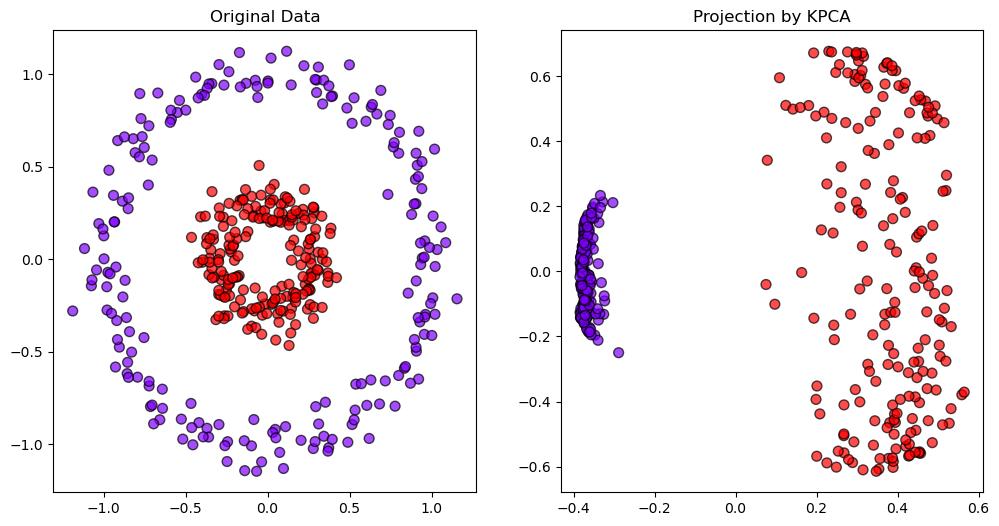

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax2.scatter(X_kpca[:, 0], X_kpca[:, 1], c=yc, cmap='rainbow',
           s=50, edgecolor='k' ,alpha=.7)
ax1.scatter(Xc[:, 0], Xc[:, 1], c=yc, cmap='rainbow',
           s=50, edgecolor='k',alpha=.7)
ax2.set_title("Projection by KPCA")
ax1.set_title("Original Data")
plt.show()

### SVD (Singular Value Decomposition)

Given any matrix $A$, we can rewrite it as a product $A=U\Sigma V^T$, where $U$ and $V$ are square, orthonormal matricies, and $\Sigma$ is a a diagonal matrix of the same shape as $A$. Numbers along diagonal of matrix $\Sigma$ are called singular values and they equal to square roots of eigenvalues of matrix $AA^T$. Moreover, they are aranged in descending order. By picking few largest singular values and cutting columns of $U$ and $V$ so that product makes sense, we reduce the dimension of our data as well.

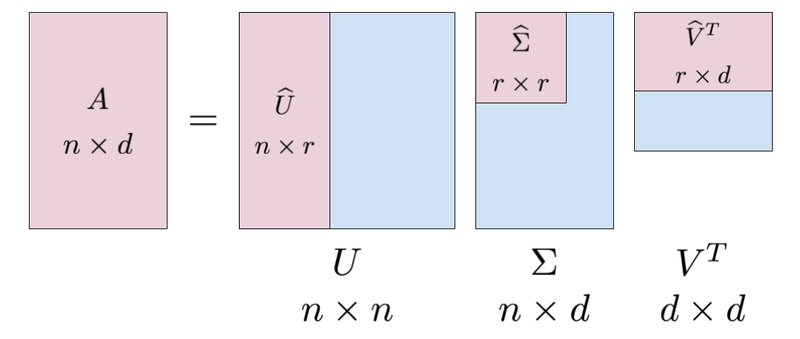

NOTE: If $A$ is our data set, then $AA^T$ is just a multiple of covariance matrix. So, this is the same as PCA approach, except we dont actually center the data. This can be a good way to reduce the size of our data. As an example, I will apply it to a data set of images.

In [13]:
digits,_=datasets.load_digits(return_X_y=True)
digits.shape

(1797, 64)

So we have 1797 images. Each of those are 8 by 8 pixels totaling 64 pixels. This means, that each image is represented as a point in 64-dimensional space. Here is an image of one of those:

In [136]:
Index=6
image = digits[Index]
image

array([ 0.,  0.,  0., 12., 13.,  0.,  0.,  0.,  0.,  0.,  5., 16.,  8.,
        0.,  0.,  0.,  0.,  0., 13., 16.,  3.,  0.,  0.,  0.,  0.,  0.,
       14., 13.,  0.,  0.,  0.,  0.,  0.,  0., 15., 12.,  7.,  2.,  0.,
        0.,  0.,  0., 13., 16., 13., 16.,  3.,  0.,  0.,  0.,  7., 16.,
       11., 15.,  8.,  0.,  0.,  0.,  1.,  9., 15., 11.,  3.,  0.])

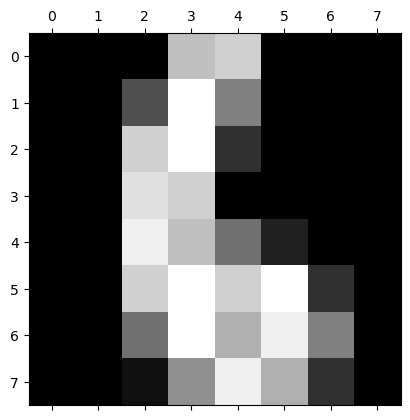

In [138]:
image = image.reshape((8, 8))
plt.matshow(image, cmap = 'gray')

In [140]:
svd = TruncatedSVD(n_components=6)
data_reduced = svd.fit_transform(digits)
data_reduced.shape

(1797, 6)

In [142]:
data_reduced[Index]

array([53.13759473, 21.32504381,  5.5450968 , 14.83114983, -5.01763526,
        4.72802317])

In [144]:
image_reduced = svd.inverse_transform(data_reduced[Index].reshape(1,-1))
image_reduced = image_reduced.reshape((8,8))

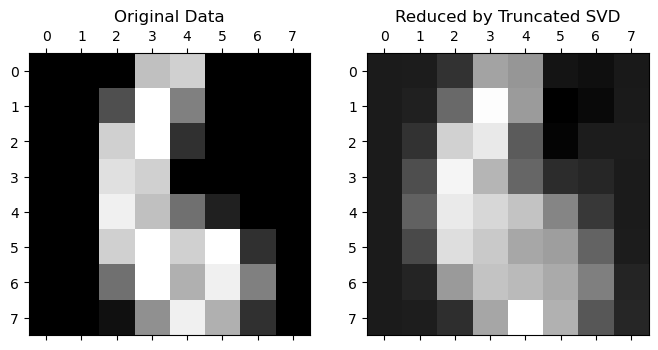

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.matshow(image, cmap = 'gray')
ax2.matshow(image_reduced, cmap = 'gray')
ax2.set_title("Reduced by Truncated SVD")
ax1.set_title("Original Data")
plt.show()

Note, `inverse_transform` can be applied in PCA or KPCA case as well. What it does is it projects our reduced data back into original dimensions. We can't get the original values since we lost some information during dimension reduction. This is in essence our approximation.

PCA, KPCA and SVD didn't care about labels. This means they are unsupervised algorithms. Next we will look at the supervised algorithm.

### LDA (Linear Discriminant Analysis)

LDA is supervised algorithm. This means we are using label (i.e. classes) as part of our dimensionality reduction. The goal of LDA is two-fold:

1. We want to maximize the spread of data similar to PCA. More precisely, we want o maximize distances between means of each class (This is called between-class variance).
2. We want to minimize spread of data inside each single class. In other words, we want each class to be clumped as much as possible. (This is called within-class variance)
  
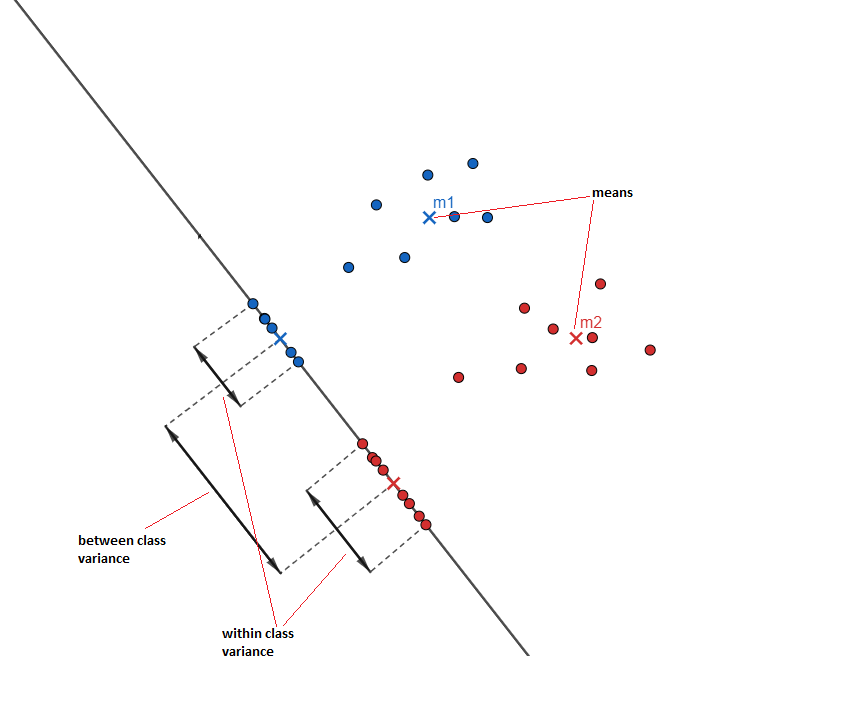

To see why we need both conditions, consider the following example below. Here, L1 line maximizes between class variance and ignores the second condition, while L2 line does both conditions:

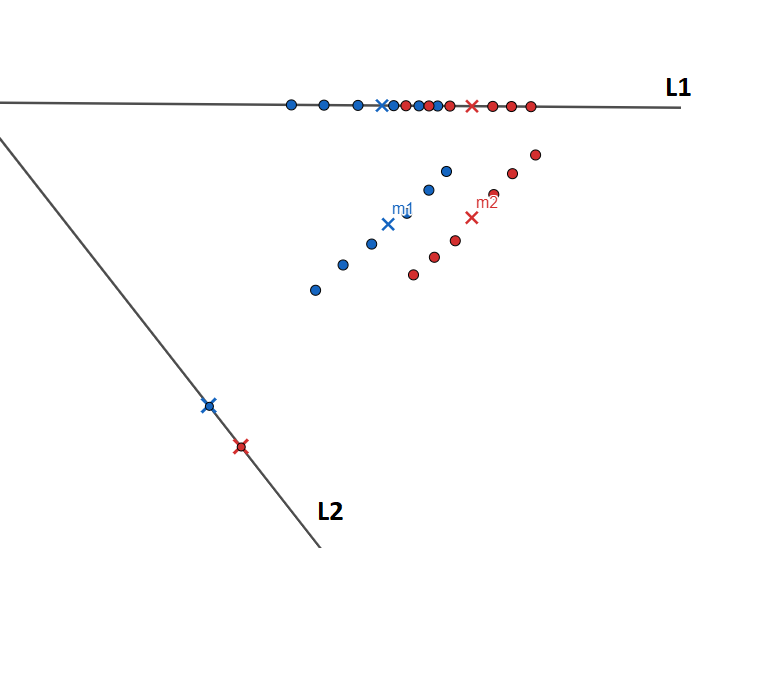

The math to achieve this is a bit more complex and requires deeper linear algebra. The goal is to find a matrix $M$ that consists of vectors on which we will project our data. To do that, we will first find two matricies: $S_w$ (within-class scatter matrix) and $S_b$ (between class scatter matrix).

The first one consists of sums of covariance matricies of each class individualy. Suppose we have $n$ classes, where $i$-th class has $n_i$ data points with a mean $m_i$. Then
$$S_w=\sum_{i=1}^n \frac{1}{n_i-1}s_i^2=\sum_{i=1}^n \left( \frac{1}{n_i-1}\sum_{j=1}^{n_i} ({\bf x_j - m_i})({\bf x_j - m_i})^T\right)$$

This is very similar to PCA example (we centralize by subtracting means).

For the second matrix, the goal is to compare means of individual classes to the common mean. So if $M$ is common mean, then

$$S_b=\sum_{i=1}^n n_i (m_i-M)(m_i-M)^T$$

Since we want to maximize between class and variance but minimize within class variance, we invert $S_w$ so that we can maximize it as well. and multiply the matricies $S_w^{-1}S_b$. Finally we look at a few eigenvectors corresponding to largest eigenvalues to get our subspace similar to PCA. Few notes here:

1. Rank of $S_b$ is $n-1$. This means maximum dimensions we can get is $n-1$. (i.e. if we have three classes, you can reduce it to either 1 or 2 dimension only)
2. Resulting eigenvectors are not orthogonal like they were for PCA. We are projecting on each vector individually and then distorting our data to make them orthogonal.

Now let's apply LDA on our Iris set to reduce it to 2 dim:

In [28]:
lda = LDA(n_components=2)   
X_lda = lda.fit_transform(Xn, y)

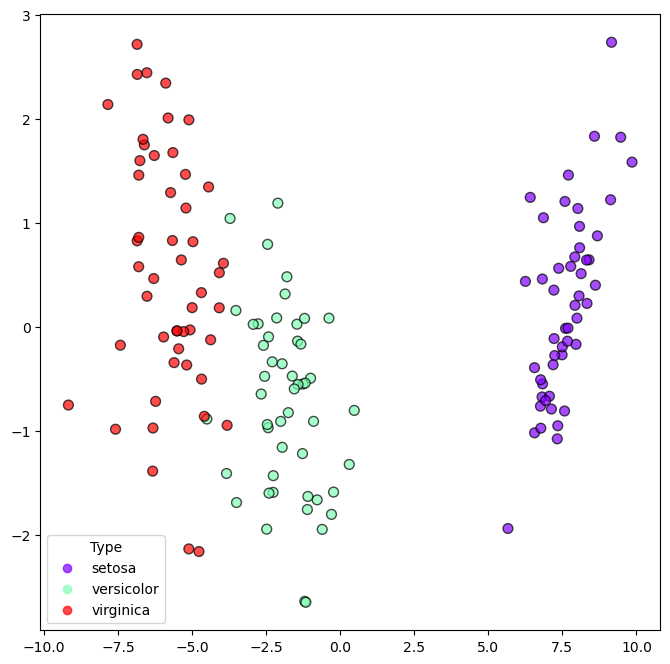

In [29]:
plt.figure(figsize=(8,8))
ax = plt.scatter(x=X_lda[:, 0], y=X_lda[:, 1], c=y, s=50, cmap='rainbow', edgecolor='k',alpha=.7)    

plt.legend(ax.legend_elements(prop='colors')[0], dataset.target_names, title='Type')
ax.legend_elements(prop='colors', num=None)
plt.show()

### t-SNE (t-Distributed Stochastic Neighbor Embedding)

So far we looked at 2 types of dimensionality reduction: decomposition (PCA, SVD, KPCA) and Discriminant Analysis (LDA). All of them a linear algorithms. Unless we use kernel trick (KPCA), we dont do well with non-linear data. Next we will briefly look at Embedding type of algorithm. More specifically, t-Distributed Stochastic Neighbor Embedding.

It works in the following way. Suppose we have a data set $X=\{x_1, x_2, \dots , x_n \}$. Then we do the following 3 steps:

1. Calculate pairwise similarity $p_{ij}$ of points $x_i$ and $x_j$ for $i, j$ in high dimensions using Gaussian kernel. The further two points are from each other, the lower the probability assigned to the pair.

To do this, we calculate $$p_{i|j}=\frac{exp(-||x_i-x_j||^2/2\sigma_i^2}{\sum_{k\neq i}exp(-||x_i-x_k||^2/2\sigma_i^2}$$ and similarly $p_{j|i}$. And then take the average and divide by $n$:

$$p_{ij}=\frac{p_{i|j}+p_{j|i}}{2n}$$

Note that what this does is it creates a distribution for each point $x_i$ of its neighbors for total of $n$ distributions $P_i$.

2. Create "similar" distributions $Q_i$ in the lower dimensional space that preserves pairwise similarity. We would start with some random set $Y=\{y_1, y_2, \dots , y_n\}$ in the lower dimension. Calculate pairwise similarity using t-distribution 1 degree of freedom:

$$q_{ij}=\frac{(1+||y_i-y_j||^2)^{-1}}{\sum_{k \neq i}(1+||y_i-y_k||^2)^{-1}}$$
   
3. Minimize the sum of KL-divergences between distributions using gradient descent. In other words, compute

$$ \sum_{i=1}^n D_{KL}(P_i||Q_i) = \sum_{i=1}^n \sum_{j=1}^n p_{ij}\ln\left(\frac{p_{ij}}{q_{ij}}\right)$$

And the use gradient descent over $Y$ to minimize this sum.


Finally, we usually use another parameter called Perplexity with t-SNE. In essence, the higher perplexity, the more likely we are to consider further points as neighbors. Usual values for Perplexity is between 5 and 50.


Let's apply it to digits data set and reduce it to only two dimension. Then, compare how PCA and LDA would fare

In [30]:
digits,y=datasets.load_digits(return_X_y=True)
digits_final = TSNE(perplexity=30).fit_transform(digits)

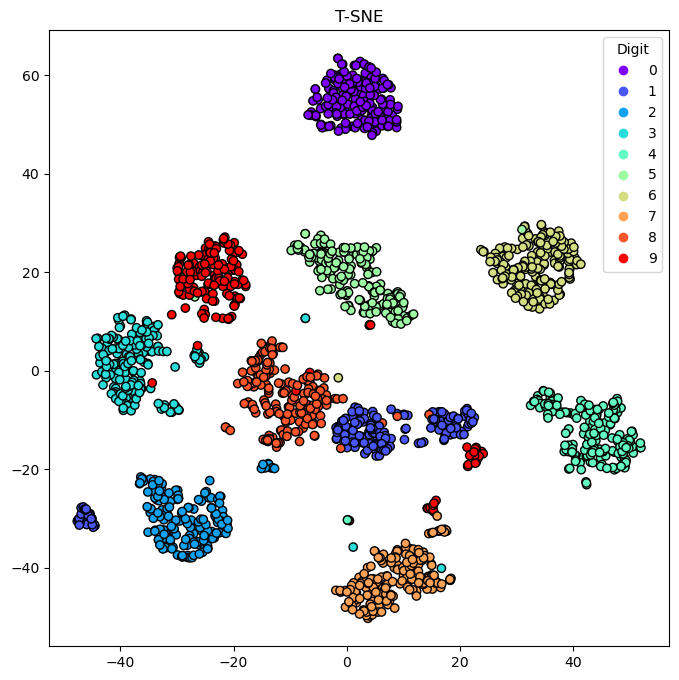

In [31]:
plt.figure(figsize=(8,8))
ax = plt.scatter(x=digits_final[:, 0], y=digits_final[:, 1], c=y, cmap='rainbow', edgecolor='k')    

plt.legend(ax.legend_elements(prop='colors')[0], y, title='Digit')
ax.legend_elements(prop='colors', num=None)
plt.title("T-SNE")
plt.show()

In [32]:
lda2 = LDA(n_components=2)   
X_lda2 = lda2.fit_transform(digits, y)

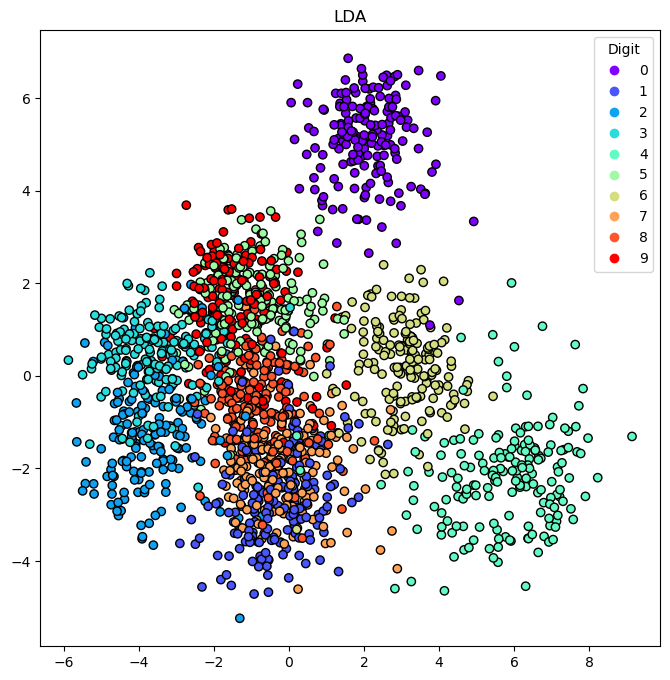

In [33]:
plt.figure(figsize=(8,8))
ax = plt.scatter(x=X_lda2[:, 0], y=X_lda2[:, 1], c=y, cmap='rainbow', edgecolor='k')    

plt.legend(ax.legend_elements(prop='colors')[0], y, title='Digit')
ax.legend_elements(prop='colors', num=None)
plt.title("LDA")
plt.show()

In [34]:
pca = PCA(n_components=2)
Xpca3=pca.fit_transform(digits)

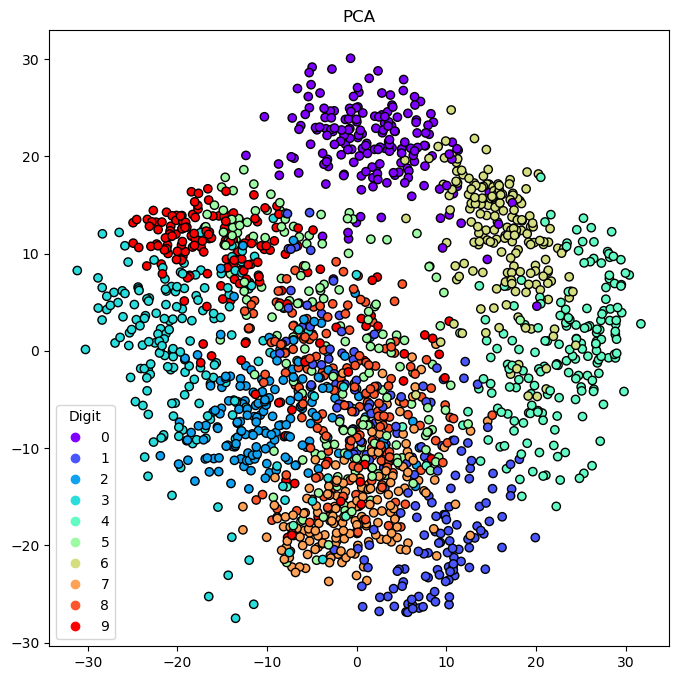

In [35]:
plt.figure(figsize=(8,8))
ax = plt.scatter(x=Xpca3[:, 0], y=Xpca3[:, 1], c=y, cmap='rainbow', edgecolor='k')    

plt.legend(ax.legend_elements(prop='colors')[0], y, title='Digit')
ax.legend_elements(prop='colors', num=None)
plt.title("PCA")
plt.show()

And just to show you that using Kernel PCA is not always a good decision:

In [61]:
kpca = KernelPCA(n_components=2, kernel="cosine", fit_inverse_transform=True, gamma=20)
Xpca4=kpca.fit_transform(digits)

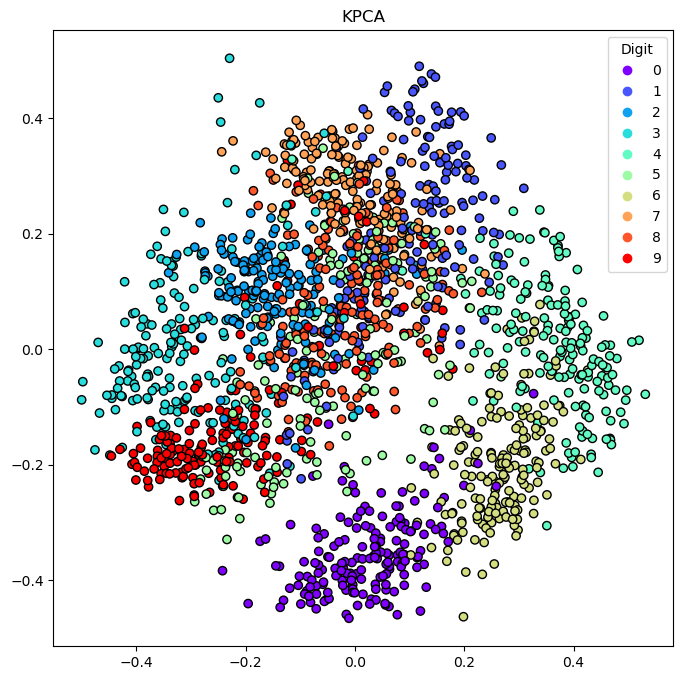

In [62]:
plt.figure(figsize=(8,8))
ax = plt.scatter(x=Xpca4[:, 0], y=Xpca4[:, 1], c=y, cmap='rainbow', edgecolor='k')    

plt.legend(ax.legend_elements(prop='colors')[0], y, title='Digit')
ax.legend_elements(prop='colors', num=None)
plt.title("KPCA")
plt.show()